In [1]:
%pylab inline
import pandas as pd
import sys
import gc

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
from numba import jit 
from sklearn.metrics import mean_squared_error, r2_score
@jit
def qwk(a1, a2, max_rat=20):
    assert(len(a1) == len(a2))
    a1 = np.asarray(a1, dtype=int)
    a2 = np.asarray(a2, dtype=int)

    hist1 = np.zeros((max_rat + 1, ))
    hist2 = np.zeros((max_rat + 1, ))

    o = 0
    for k in range(a1.shape[0]):
        i, j = a1[k], a2[k]
        hist1[i] += 1
        hist2[j] += 1
        o +=  (i - j) * (i - j)

    e = 0
    for i in range(max_rat + 1):
        for j in range(max_rat + 1):
            e += hist1[i] * hist2[j] * (i - j) * (i - j)

    e = e / float(a1.shape[0])

    return 1 - o / e


def clip_pred(pred):
    pred=np.round(pred)
    pred[pred<0]=0
    pred[pred>20]=20
    return pred.astype(np.int8)

def qwk_score(y_true,y_pred):
    #print "RMSE", np.sqrt(mean_squared_error(y_true,y_pred))
    ypred=clip_pred(y_pred)
    return qwk(y_true,ypred)
    

In [3]:
import fastparquet
%time df=fastparquet.ParquetFile("../../input/train_num_combined_latest_target_v2.parq").to_pandas()

CPU times: user 2.87 s, sys: 1.59 s, total: 4.46 s
Wall time: 14.2 s


In [4]:
df=df.loc[np.random.permutation(df.index)]
X=df.drop(['target','fold'],axis=1)
y=df['target']
trainx=X[y>=0]
trainy=y[y>=0]
testx=X[y<0]
folds=df[y>=0]['fold']
print trainx.shape,testx.shape,trainy.shape, len(folds),set(trainy)

(5203955, 54) (1378521, 54) (5203955,) 5203955 set([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20])


In [5]:
gc.collect()

9958

In [6]:
import lightgbm as lgb

In [7]:
def shuffle_XY(X,y):
    idx=np.random.permutation(range(len(y)))
    return X[idx],y[idx]
def shuffle_XY2(X,y):
    idx=np.random.choice(range(len(y)),replace=True,size=len(y))
    return X[idx],y[idx]

# cv

In [8]:
from sklearn.model_selection import GridSearchCV,ParameterGrid,ParameterSampler
from sklearn.metrics import  make_scorer
from multiprocessing import Pool

In [10]:
def make_model(i, d_train,d_valid, colsample_bytree=1,num_leaves=31,subsample=1,
               learning_rate=0.03,max_bin=127,
               min_data_in_leaf=20,lambda_l2=0,
               min_sum_hessian_in_leaf=1e-3, C=0.001,
               objective='binary' ):
        models=[]
        scores=[]
        if 1:
            params = {
                'task': 'train',
                'boosting_type': 'gbdt',
                'objective': objective,
                'metric': {'rmse'},
                'num_leaves':num_leaves,
                'learning_rate': learning_rate,
                'feature_fraction': colsample_bytree,
                'bagging_fraction': subsample,
                'min_data_in_leaf': min_data_in_leaf,
                'min_sum_hessian_in_leaf': min_sum_hessian_in_leaf,
                'lambda_l2': lambda_l2,
                'max_bin': max_bin,
                'bagging_freq': 5,
                'nthread': 8,
                'verbose': 0,
                'metric_freq': 50,
                'train_metric': True
            }
            print str(params)
            gbm = lgb.train(params,
                            d_train,
                            num_boost_round=1000,
                            valid_sets=d_valid,
                            early_stopping_rounds=50)

            models.append(gbm)
        return models[0]


In [11]:
param={u'num_leaves': 255, u'colsample_bytree': 0.7, u'learning_rate': 0.04, u'lambda_l2': 1, u'subsample': 1, u'min_data_in_leaf': 30, u'max_bin': 255, u'objective': u'regression', u'min_sum_hessian_in_leaf': 0.001}

In [14]:
def train_once(fold):
    print fold
    X_train=trainx[(folds<>fold)]
    y_train=trainy[(folds<>fold)]
    X_valid=trainx[(folds==fold)]
    y_valid=trainy[(folds==fold)]

    d_train = lgb.Dataset(X_train, label=y_train)
    d_valid = lgb.Dataset(X_valid, label=y_valid)

    regr = make_model(0, d_train,d_valid, **param)
    a= pd.Series(regr.predict(testx,num_iteration=regr.best_iteration),index=testx.index) 
    b=pd.Series(regr.predict(X_valid,num_iteration=regr.best_iteration),index=X_valid.index) 
    return a,b

def train():
    lst_valid=[]
    lst_test=[]
    p = Pool(3,maxtasksperchild=1)
    result=p.map(train_once, range(5),chunksize=1)
    for a,b in result:
        lst_test.append(a)
        lst_valid.append(b)
    p.terminate()
    p.join() 
    return lst_valid,lst_test

In [ ]:
lst_valid,lst_test=train()

In [16]:
name='lgb0'

In [17]:
l1_test_pred=(reduce(lambda u,v:u+v,lst_test)/float(len(lst_test))).astype(np.float32)
l1_test_pred.name=name+"_pred"
l1_train_pred=pd.concat(lst_valid).loc[trainx.index].astype(np.float32)
l1_train_pred.name=name+"_pred"
np.sqrt(r2_score(trainy,l1_train_pred)),qwk_score(trainy,l1_train_pred),mean_squared_error(trainy,l1_train_pred)

(0.77350620555455418, 0.7444177414115652, 3.5466249)

In [18]:
import cPickle as pickle
pickle.dump(l1_train_pred,open("../level1_train/{}_train_l1pred.pkl".format(name),'wb'))
pickle.dump(l1_test_pred,open("../level1_train/{}_test_l1pred.pkl".format(name),'wb'))

0.704569607572 0.970701844396


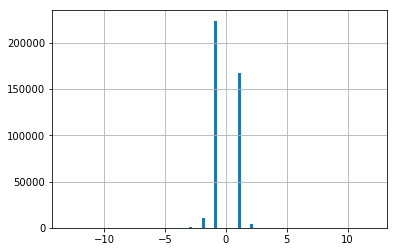

In [32]:
a=clip_pred(pickle.load(open("../level1_train/xgb0_test_l1pred.pkl")))
b=clip_pred(pickle.load(open("../level1_train/ridge0_test_l1pred.pkl")))
b=b.loc[a.index]
d=(a-b)
print mean(d==0),np.corrcoef(a,b)[0,1]
d[d<>0].hist(bins=100)

0.912938576924 0.991971629668 0.991954628887


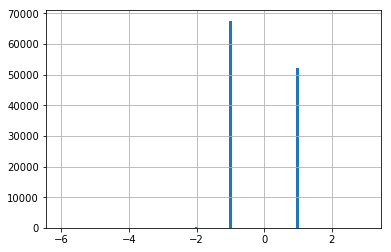

In [29]:
a=clip_pred(pickle.load(open("../level1_train/xgb0_test_l1pred.pkl")))
b=clip_pred(pickle.load(open("../level1_train/lgb0_test_l1pred.pkl")))
b=b.loc[a.index]
d=(a-b)
print mean(d==0),np.corrcoef(a,b)[0,1],qwk_score(a,b)
d[d<>0].hist(bins=100)

In [31]:
from sklearn.metrics import confusion_matrix
pd.DataFrame(confusion_matrix(a.values,b.values)) 

0      1       2       3       4       5       6       7      8      9   \
0   344     98       0       0       0       0       0       0      0      0   
1    43  60395    3815       0       0       0       0       0      0      0   
2     0   2226  180565    7770       0       0       0       0      0      0   
3     0      0    5754  229018    9597       3       0       0      0      0   
4     0      0       2    7454  221504    9922       6       0      1      0   
5     0      0       0       4    8199  185701    8061      15      1      0   
6     0      0       0       0       3    8134  139851    7623     26      5   
7     0      0       0       0       0       3    6762  100018   7562     34   
8     0      0       0       0       0       0       4    5031  63492   5532   
9     0      0       0       0       0       0       0       0   3400  37552   
10    0      0       0       0       0       0       0       0      3   2168   
11    0      0       0       0       0       0       0       0      0      3   
12    0      0       0       0       0       0       0       0      0      0   
13    0      0       0       0       0       0       0       0      0      0   
14    0      0       0       0       0       0       0       0      0      0   
15    0      0       0       0       0       0       0       0      0      0   
16    0      0       0       0       0       0       0       0      0      0   

       10     11    12    13   14  15  16  
0       0      0     0     0    0   0   0  
1       0      0     0     0    0   0   0  
2       0      0     0     0    0   0   0  
3       0      0     0     0    0   0   0  
4       0      0     0     0    0   0   0  
5       0      0     0     0    0   0   0  
6       0      0     1     0    0   0   0  
7       4      4     0     0    0   0   0  
8      34      5     0     0    0   0   0  
9    3212     44     2     1    0   0   0  
10  20296   2051    43     4    0   0   0  
11   1385  11499  1362    34    1   0   0  
12      2    999  5647   675   16   0   0  
13      0      0   426  2183  307   8   0  
14      0      0     0    95  418  22   1  
15      0      0     1     0    5  21   3  
16      0      0     0     0    0   5   1